In [1]:
#imports
import numpy as np
import tensorflow as tf
import cv2
import lucid.scratch.web.svelte as lucid_svelte
import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
import lucid.optvis.objectives as objectives
import os
import math

from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
from lucid_load_model import CovidNetB
from data import process_image_file
from lucid_utils import read_results_file, get_percentile, replace_activations, get_activation_mask

covidnet = CovidNetB()

In [2]:
%%html_define_svelte ActivationMask

<div class="figure">
    <div class="image-wrapper">
        <div class="input_image">
            <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        </div>
        <div class="image grad-image" style="background-image: url({{masked_url}});"></div>
    </div>
</div>


<style>
    .figure {
        
    }
    .image-wrapper {
        display: flex;
        justify-content: space-between;
    }
    .input_image, .grad-image {
        width:50%;
        max-width: 480px;
        position: relative;
    }
    .image {
        height: 480px;
        background-repeat: no-repeat;
        background-size: cover;
        background-position: center;
    }
</style>

Trying to build svelte component from html...
svelte compile --format iife C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_y_no4a8_\ActivationMask_87d3130a_0073_47fe_8472_6cbcaef90b56.html > C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_y_no4a8_\ActivationMask_87d3130a_0073_47fe_8472_6cbcaef90b56.js
b'svelte version 1.64.1\ncompiling ..\\..\\..\\..\\..\\..\\..\\..\\CUDDLE~1\\AppData\\Local\\Temp\\svelte_y_no4a8_\\ActivationMask_87d3130a_0073_47fe_8472_6cbcaef90b56.html...\n'


In [3]:
def get_acts(result='normal_0', layer='conv5_block3_out/add'):
    result_dict = read_results_file()[result]
    image_file = result_dict['image_name']
        
    processed_img = process_image_file(os.path.join('data/test', image_file), 0, 480)
    
    firings_file = 'output/lucid/conv5/firings_distribution.txt'
    #average firing of each channel over entire test set
    firings = np.loadtxt(firings_file)
    
    # Compute the activations
    with tf.Graph().as_default() as graph, tf.Session():
        t_input = tf.placeholder(tf.float32, [480, 480, 3])
        T = render.import_model(covidnet, t_input, t_input)
        acts = T(layer).eval({t_input: processed_img})[0]
    
    acts = -acts
    replace_activations(acts, firings)

    tf.Session().close()
    
    return acts

In [4]:
def covidnet_activation_mask(result='normal_0', channel=0, acts=None):
    #'dab2f334-331c-42c7-af09-a997092464b0.png'
    result_dict = read_results_file()[result]
    image_file = result_dict['image_name']
        
    processed_img = process_image_file(os.path.join('data/test', image_file), 0, 480)
    
    if (acts is None):
        acts = get_acts(result)
    
    #get the masked image
    masked_img = get_activation_mask(processed_img, acts, channel)
    
    lucid_svelte.ActivationMask({
        "image_url": _image_url(processed_img),
        "masked_url": _image_url(masked_img),
    })

In [5]:
#suppress warnings from tensorflow
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
acts = get_acts(result='pneumonia_1')


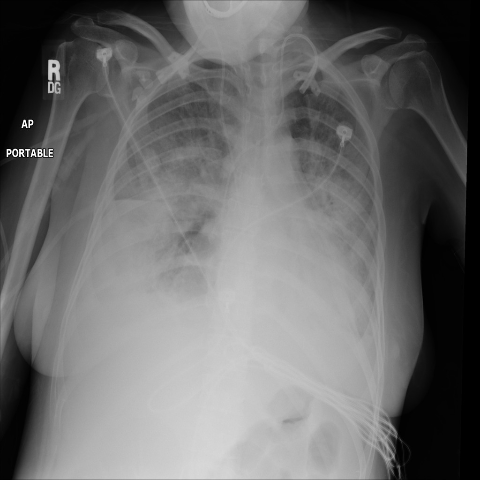
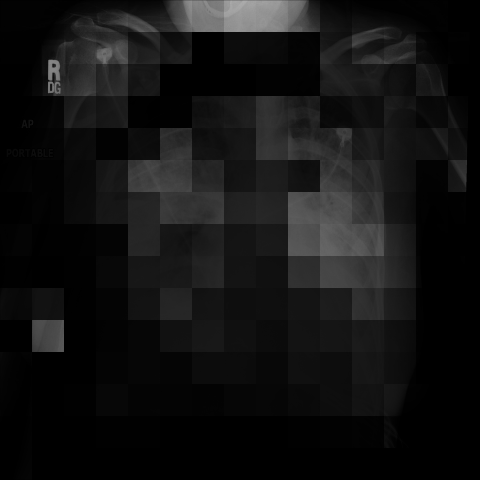

In [6]:
covidnet_activation_mask(result='pneumonia_2', channel=1824, acts=acts)


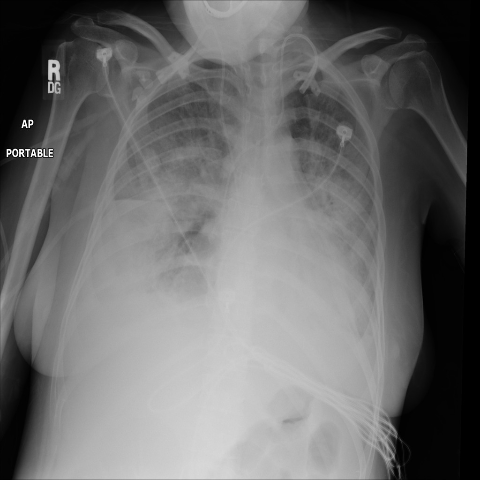
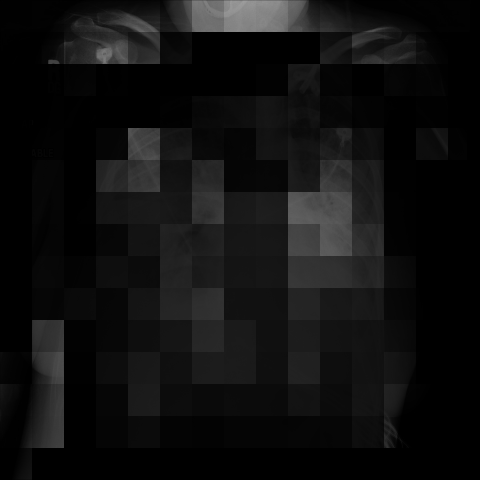

In [7]:
covidnet_activation_mask(result='pneumonia_2', channel=800, acts=acts)